In [1]:
from data.pancreas import preprocessing
import giraffe 
from netZooPy.otter.otter import otter
import numpy as np
import pandas as pd

In [2]:
cache = True

In [3]:
if not cache:
    preprocessing.generate_data()

In [2]:
gtex = pd.read_csv("data/pancreas/raw/xprs_panc_gtex_snail.tsv", sep = '\t', index_col = 0)
tcga = pd.read_csv("data/pancreas/raw/xprs_panc_tcga_snail.tsv", sep = '\t', index_col = 0)
genes = [gene[0:15] for gene in gtex.index]
gtex = pd.DataFrame(gtex.to_numpy(), index = genes, columns = gtex.columns)
tcga = pd.DataFrame(tcga.to_numpy(), index = genes, columns = tcga.columns)
motif = pd.read_csv("data/pancreas/motif.txt", index_col = 0)
ppi = pd.read_csv("data/pancreas/ppi.csv", index_col = 0)

In [72]:
giraffe_gtex = giraffe.Giraffe(gtex.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0])).get_regulation()
pd.DataFrame(giraffe_gtex, index = gtex.index, columns = motif.columns).to_csv("data/pancreas/giraffe_gtex.csv")

In [7]:
giraffe_tcga = giraffe.Giraffe(tcga.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0])).get_regulation()
pd.DataFrame(giraffe_tcga, index = gtex.index, columns = motif.columns).to_csv("data/pancreas/giraffe_tcga.csv")

In [8]:
tcga_otter = otter(motif.to_numpy().T, ppi.to_numpy() + np.eye(ppi.shape[0]), np.corrcoef(tcga.to_numpy()), Iter = 200)
pd.DataFrame(tcga_otter, index = motif.columns, columns = gtex.index).to_csv("data/pancreas/tcga_otter.csv")

In [9]:
gtex_otter = otter(motif.to_numpy().T, ppi.to_numpy() + np.eye(ppi.shape[0]), np.corrcoef(gtex.to_numpy()), Iter = 200)
pd.DataFrame(gtex_otter, index = motif.columns, columns = gtex.index).to_csv("data/pancreas/gtex_otter.csv")

# Oncogenes vs Tumor Suppressor Genes

In [9]:
giraffe_gtex = pd.read_csv("data/pancreas/giraffe_gtex.csv", index_col = 0)
giraffe_tcga = pd.read_csv("data/pancreas/giraffe_tcga.csv", index_col = 0)
census = pd.read_csv("data/pancreas/raw/Census_allThu Feb 2 22 18 29 2023.csv")
translate = pd.read_csv("data/pancreas/raw/gen_v26_mapping.csv")

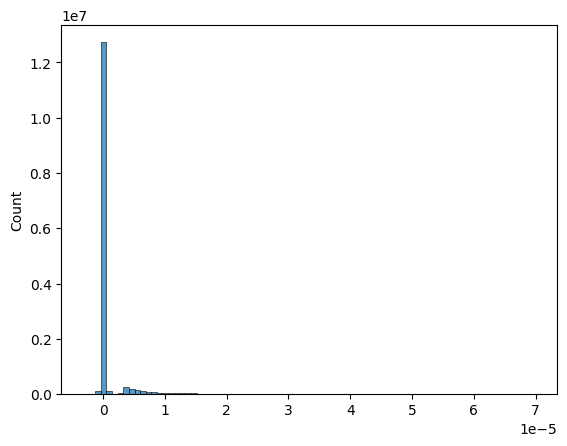

In [28]:
import seaborn
import matplotlib.pyplot as plt 

g = seaborn.histplot(giraffe_gtex.to_numpy().flatten(), bins = 80)

<AxesSubplot:ylabel='Count'>

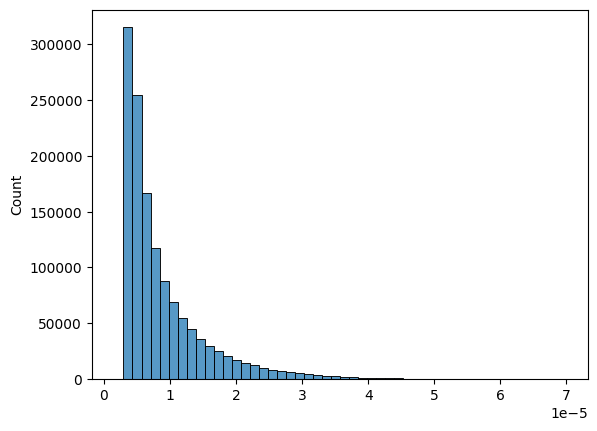

In [16]:
seaborn.histplot(a, bins = 50)

In [20]:
b = []
for i in range(motif.to_numpy().shape[0]):
    for j in range(motif.to_numpy().shape[1]):
        if motif.to_numpy()[i, j] == 0:
            b.append(giraffe_gtex.to_numpy()[i, j])

<AxesSubplot:ylabel='Count'>

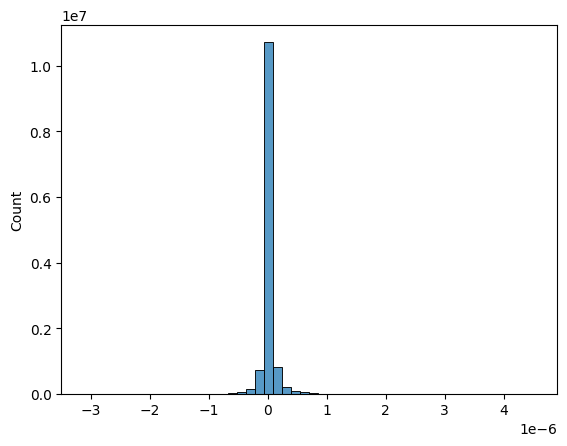

In [21]:
seaborn.histplot(b, bins = 50)

<AxesSubplot:ylabel='Count'>

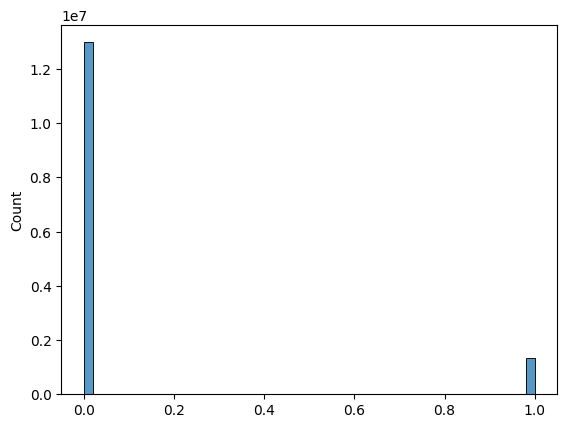

In [10]:
seaborn.histplot(motif.to_numpy().flatten(), bins = 50)

In [35]:
df = census[census['Tier'] == 1][['Gene Symbol', 'Role in Cancer', 'Tumour Types(Somatic)']]
sign = []
for elem in census['Role in Cancer']:
    if isinstance(elem, float):
        sign.append(0)
        continue
    if 'TSG' in elem:
        sign.append(-1)
    elif 'oncogene' in elem:
        sign.append(1)
    else:
        sign.append(0)
df['sign'] = pd.DataFrame(sign)

In [37]:
from scipy import spatial
def p_val(A, B, gene):
    real = spatial.distance.sqeuclidean(A.loc[gene], B.loc[gene])
    cnt = 0
    for i in range(100):
        if real < spatial.distance.sqeuclidean(np.random.permutation(A.loc[gene]), np.random.permutation(B.loc[gene])):
            #print(str(real) + " " + str(spatial.distance.cosine(np.random.permutation(A.loc[gene]), np.random.permutation(B.loc[gene]))))
            cnt += 1
    return cnt / 100

scores = np.sum(giraffe_gtex - giraffe_tcga, axis = 1)

hit = 0
tot = 0
for gene in df['Gene Symbol']:
    if isinstance(df[df['Gene Symbol'] == gene]['Tumour Types(Somatic)'].values[0], float):
        continue
    if 'pancr' not in df[df['Gene Symbol'] == gene]['Tumour Types(Somatic)'].values[0]:
        continue
    if gene not in set(translate['gene_name']):
        continue
    translation = translate[translate['gene_name'] == gene]['gene_id'].values[0][0:15]
    if translation not in scores.index:
        continue
    gt = df[df['Gene Symbol'] == gene]['sign'].values[0]
    p = p_val(giraffe_gtex, giraffe_tcga, translation)
    if gt == 0:
        continue
    real = scores[translation]
    tot += 1
    if real > 0 and gt == 1:
        hit += 1
        print(str(gene) + " with p-val " + str(p) + " and correct direction")
    elif real < 0 and gt == -1:
        hit += 1
        print(str(gene) + " with p-val " + str(p) + " and correct direction")
    else:
        print(str(gene) + " with p-val " + str(p) + " and wrong direction")
#print(str(hit) + " " + str(tot))

ACVR1B with p-val 1.0 and correct direction
ACVR2A with p-val 1.0 and wrong direction
AKT2 with p-val 1.0 and correct direction
APC with p-val 1.0 and correct direction
ATRX with p-val 1.0 and correct direction
BRAF with p-val 1.0 and wrong direction
DAXX with p-val 1.0 and wrong direction
EP300 with p-val 1.0 and correct direction
FAT1 with p-val 1.0 and correct direction
FAT4 with p-val 1.0 and wrong direction
GNAS with p-val 1.0 and wrong direction
HIF1A with p-val 1.0 and correct direction
KRAS with p-val 1.0 and correct direction
MAP2K4 with p-val 1.0 and correct direction
MEN1 with p-val 1.0 and correct direction
PREX2 with p-val 1.0 and correct direction
RNF43 with p-val 1.0 and correct direction
SMAD4 with p-val 1.0 and correct direction
SND1 with p-val 1.0 and wrong direction
STK11 with p-val 1.0 and correct direction


In [93]:
from scipy import spatial
def p_val(A, B, gene):
    vec = np.sum(np.abs(A - B), axis = 1)
    return 1 - vec.argsort().argsort().loc[gene] / len(vec)

scores = np.sum(giraffe_gtex - giraffe_tcga, axis = 1)

hit = 0
tot = 0
idx1 = []
for gene in df['Gene Symbol']:
    if isinstance(df[df['Gene Symbol'] == gene]['Tumour Types(Somatic)'].values[0], float):
        continue
    if 'pancr' not in df[df['Gene Symbol'] == gene]['Tumour Types(Somatic)'].values[0]:
        continue
    if gene not in set(translate['gene_name']):
        continue
    translation = translate[translate['gene_name'] == gene]['gene_id'].values[0][0:15]
    if translation not in scores.index:
        continue
    idx1.append(translation)
    gt = df[df['Gene Symbol'] == gene]['sign'].values[0]
    p = p_val(giraffe_gtex, giraffe_tcga, translation)
    if p > 0.10 :
        continue
    if gt == 0:
        continue
    real = scores[translation]
    tot += 1
    if real > 0 and gt == -1:
        hit += 1
        print(str(gene) + " with p-val " + str(p) + " and correct direction")
    elif real < 0 and gt == 1:
        hit += 1
        print(str(gene) + " with p-val " + str(p) + " and correct direction")
    else:
        print(str(gene) + " with p-val " + str(p) + " and wrong direction")
#print(str(hit) + " " + str(tot))

APC with p-val 0.061309925725860914 and wrong direction
GNAS with p-val 0.043664190862030106 and correct direction
SND1 with p-val 0.022237227098807155 and correct direction


In [94]:
idx1

['ENSG00000135503',
 'ENSG00000121989',
 'ENSG00000105221',
 'ENSG00000134982',
 'ENSG00000085224',
 'ENSG00000157764',
 'ENSG00000204209',
 'ENSG00000100393',
 'ENSG00000083857',
 'ENSG00000196159',
 'ENSG00000087460',
 'ENSG00000100644',
 'ENSG00000133703',
 'ENSG00000065559',
 'ENSG00000133895',
 'ENSG00000046889',
 'ENSG00000108375',
 'ENSG00000141646',
 'ENSG00000197157',
 'ENSG00000118046']

<AxesSubplot:ylabel='Count'>

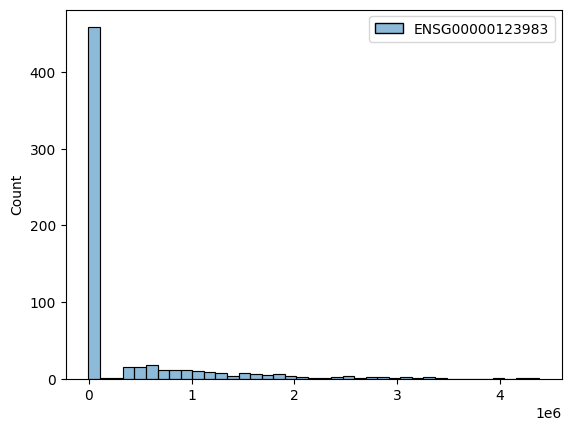

In [97]:
import matplotlib.pyplot as plt

sns.histplot([100000000000 * giraffe_gtex.loc['ENSG00000123983'], 100000000000 * giraffe_tcga.loc['ENSG00000123983']], color = ['red', 'green'])

<AxesSubplot:>

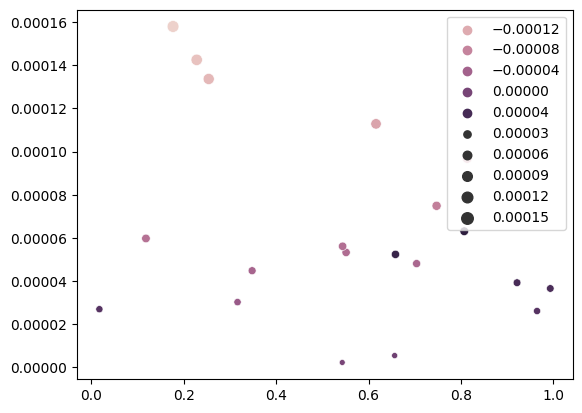

In [60]:
import seaborn as sns

sns.scatterplot(x = (np.sum(np.abs(giraffe_gtex - giraffe_tcga), axis = 1).argsort()[::-1].argsort() / giraffe_gtex.shape[0]).loc[idx1], 
                y = np.abs(np.sum(giraffe_gtex - giraffe_tcga, axis = 1)).loc[idx1],
                hue = np.sum(giraffe_gtex - giraffe_tcga, axis = 1).loc[idx1], 
                size = np.abs(np.sum(giraffe_gtex - giraffe_tcga, axis = 1)).loc[idx1]
               )

# TF Knockdown

In [267]:
giraffe_gtex = giraffe.Giraffe(gtex.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), iterations = 50).get_regulation()

In [270]:
intervention = pd.read_csv("data/pancreas/raw/ZIC2.csv")[['Target Gene', 'Mean Expr. of Control', 'Mean Expr. of Treat']]
translate = pd.read_csv("data/pancreas/raw/gen_v26_mapping.csv")
intervention['diff'] = intervention[intervention.columns[1]] > intervention[intervention.columns[2]]

In [271]:
tf_index = list(motif.columns).index('ZIC2')
score = 0
tot = 0
a = 0
b = 0
aa = 0
bb = 0
for i in range(intervention.shape[0]):
    gene = intervention.iloc[i]['Target Gene']
    if intervention['Target Gene'][i] not in set(translate['gene_name']):
        continue
    translation = translate[translate['gene_name'] == intervention['Target Gene'][i]]['gene_id'].values[0][0:15]
    if translation not in gtex.index:
        continue
    tot += 1
    if giraffe_gtex[list(gtex.index).index(translation), tf_index] > 0:
        a += 1
        if intervention.iloc[i]['diff']:
            aa += 1
            score += 1
    else:
        b += 1
        if not intervention.iloc[i]['diff']:
            bb += 1
            score += 1
print(score / tot)

0.6863169280692266


In [ ]:
'HOXB7': 0.67
'FOXO3': 0.53
'ZIC2': 0.69